In [14]:
import os
import DFA
import numpy as np
import matplotlib.pyplot as plt
import Clasifier_models as cm
from sklearn.model_selection import train_test_split
import pickle

# import seaborn as sns
import pandas as pd
from scipy.stats import t

In [22]:
data = np.load('Features.npz')
X_train, X_test, y_train, y_test = train_test_split(data['X'], data['y'], test_size=0.2)

In [23]:
table = {}
table['Clase'] = data['label_y']
for feature, vals in zip(data['features_name'], np.array(data['X']).T):
    table[feature] = vals
pd_table = pd.DataFrame(table)
pd_table.to_csv('Features_Vals.csv', index=False)

In [8]:
nombres = ['α estrella','α mínima', 'α máxima', 'Ancho', 'Alto', 'Longitud', 'C0', 'C1', 'C2']

In [24]:
# Step 1: Calculate the T-score
def calculate_t_score(sample1, sample2):
	mean1 = np.mean(sample1)
	mean2 = np.mean(sample2)
	std1 = np.std(sample1, ddof=1) 
	std2 = np.std(sample2, ddof=1)
	n1 = len(sample1)
	n2 = len(sample2)
	# print(mean1, mean2, std1**2, std2**2, n1, n2)

	t_score = (mean1 - mean2) / np.sqrt((std1**2 / n1) + (std2**2 / n2))
	# t_score = np.sqrt(n1*n2) * (mean1 - mean2) / np.sqrt((std1**2) + (std2**2))
	return t_score

def calculate_t_score_dif(sample1, sample2):
	mean1 = np.mean(sample1)
	mean2 = np.mean(sample2)
	std1 = np.std(sample1, ddof=1) 
	std2 = np.std(sample2, ddof=1)
	n1 = len(sample1)
	n2 = len(sample2)

	# print(mean1, mean2, std1**2, std2**2, n1, n2)

	t_score = np.sqrt((n1*n2*(n1 + n2 - 2)) / (n1 + n2) ) * (mean1 - mean2) / (np.sqrt((std1**2 * (n1 - 1)) + (std2**2 * (n2 - 1))) )
	return t_score

# Step 2: Determine the degrees of freedom (df)
def calculate_degrees_of_freedom(sample1, sample2):
	n1 = len(sample1)
	n2 = len(sample2)
	df = n1 + n2 - 2 # For a two-sample t-test
	return df

# Step 3: Identify the appropriate t-distribution
# (The scipy.stats.t distribution is used, which automatically considers the degrees of freedom)

# Step 4: Find the p-value
def calculate_p_value(t_score, df):
	p_value = 2 * (1 - t.cdf(np.abs(t_score), df))
	return p_value

# Step 5: Interpret the p-value
def interpret_p_value(p_value, alpha=0.05):
	if p_value < alpha:
		return "Reject the null hypothesis. There is a statistically significant difference."
	else:
		return "Fail to reject the null hypothesis. There is no statistically significant difference."

In [25]:
covid_features = pd_table[pd_table['Clase'] == 'COVID-19']
nocovid_features = pd_table[pd_table['Clase'] == 'NO COVID-19']

table_t_studet = {}

table_t_studet['Parámetro'] = []

table_t_studet['COVID-19'] = []
table_t_studet['NO COVID-19'] = []

table_t_studet['Valor P'] = []


for feature in pd_table.columns[1:]:
    
    sample1 = covid_features[feature]
    sample2 = nocovid_features[feature]
    t_score = calculate_t_score_dif(sample1, sample2)
    df = calculate_degrees_of_freedom(sample1, sample2)
    p_value = calculate_p_value(t_score, df)
    result = interpret_p_value(p_value)

    table_t_studet['Parámetro'].append(feature)
    table_t_studet['COVID-19'].append(f'{np.mean(sample1):.4f} ± {np.std(sample1):.4f}')
    table_t_studet['NO COVID-19'].append(f'{np.mean(sample2):.4f} ± {np.std(sample2):.4f}')
    table_t_studet['Valor P'].append(np.round(p_value,4))
    
    

In [26]:
table_t_studet = pd.DataFrame(table_t_studet)
table_t_studet.to_csv('table_t_studet.csv', index=False)

### Train_classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score


In [93]:
Name_Scores = ['RandomForestClassifier', 'DecisionTreeClassifier','SupportVectorMachine', 'KNeighborsClassifier','MLPClassifier','GaussianNB']
Name_Scores_short = ['RF','DT', 'SVM', 'KN', 'MLP', 'NB']
k_folds = KFold(n_splits = 10)

Scores_AUC = []
Scores_Recall = []
rf_classifier = RandomForestClassifier()                 # Random Forest
dt_classifier = DecisionTreeClassifier()                 # Decision Tree
svc_classifier = SVC(kernel='poly')                      # Support Vector Machine
knn_classifier = KNeighborsClassifier(n_neighbors=2)     # k-nearest neighbors
mlp_classifier = MLPClassifier(hidden_layer_sizes=(16,64, 64, 16),max_iter=1000) # Multilayer Perceptron
gnb_classifier = GaussianNB()

Scores_AUC.append(cross_val_score( rf_classifier, X_train, y_train, cv = k_folds,scoring='roc_auc'))
Scores_AUC.append(cross_val_score( dt_classifier, X_train, y_train, cv = k_folds,scoring='roc_auc'))
Scores_AUC.append(cross_val_score(svc_classifier, X_train, y_train, cv = k_folds,scoring='roc_auc'))
Scores_AUC.append(cross_val_score(knn_classifier, X_train, y_train, cv = k_folds,scoring='roc_auc'))
Scores_AUC.append(cross_val_score(mlp_classifier, X_train, y_train, cv = k_folds,scoring='roc_auc'))
Scores_AUC.append(cross_val_score(gnb_classifier, X_train, y_train, cv = k_folds,scoring='roc_auc'))

Scores_Recall.append(cross_val_score( rf_classifier, X_train, y_train, cv = k_folds,scoring='recall'))
Scores_Recall.append(cross_val_score( dt_classifier, X_train, y_train, cv = k_folds,scoring='recall'))
Scores_Recall.append(cross_val_score(svc_classifier, X_train, y_train, cv = k_folds,scoring='recall'))
Scores_Recall.append(cross_val_score(knn_classifier, X_train, y_train, cv = k_folds,scoring='recall'))
Scores_Recall.append(cross_val_score(mlp_classifier, X_train, y_train, cv = k_folds,scoring='recall'))
Scores_Recall.append(cross_val_score(gnb_classifier, X_train, y_train, cv = k_folds,scoring='recall'))


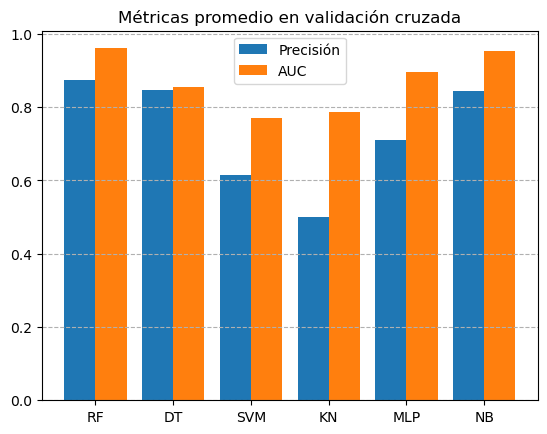

In [94]:
Score_mean_Recall = [np.mean(score) for score in Scores_Recall]
Score_std_Recall = [np.std(score) for score in Scores_Recall]

Score_mean_AUC = [np.mean(score) for score in Scores_AUC]
Score_std_AUC = [np.std(score) for score in Scores_AUC]

X_axis = np.arange(len(Name_Scores))

plt.bar(X_axis - 0.2,Score_mean_Recall, 0.4, label = 'Precisión')
# plt.errorbar(X_axis - 0.2,Score_mean_Recall, yerr=Score_std_Recall, fmt="o", color="r")

plt.bar(X_axis + 0.2,Score_mean_AUC, 0.4,label = 'AUC')
# plt.errorbar(X_axis + 0.2,Score_mean_AUC, yerr=Score_std_AUC, fmt="o", color="r")

plt.xticks(X_axis, Name_Scores_short) 
plt.legend()
plt.grid(axis='y', linestyle = '--')
plt.title('Métricas promedio en validación cruzada')
plt.show()

In [44]:
# classifier = GaussianNB()
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train,)
y_pred = classifier.predict(X_test)

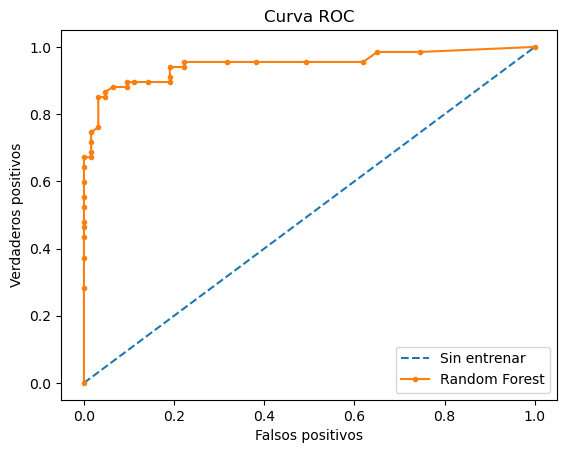

In [35]:
predicted_proba = classifier.predict_proba(X_test)
ns_probs = [0 for _ in range(len(y_test))]

fpr,tpr, thresholds = roc_curve(y_test, predicted_proba[:,1])

ns_fpr,ns_tpr, ns_thresholds = roc_curve(y_test, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.legend()
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')
plt.title('Curva ROC')
plt.show()

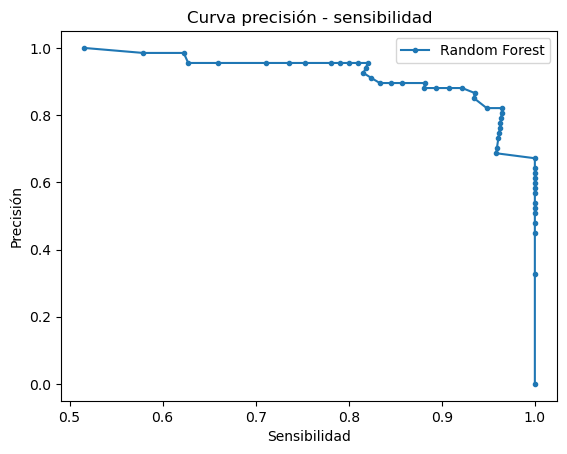

In [34]:
pre, rec, thresh = precision_recall_curve(y_test, predicted_proba[:,1])

plt.plot(pre, rec, marker='.',label='Random Forest')

plt.xlabel('Sensibilidad')
plt.ylabel('Precisión')
plt.legend()
plt.title('Curva precisión - sensibilidad')
plt.show()

Accuracy Score: 0.892 
Precision Score: 0.934 
Recall Score:  0.892 
AUC Score: 0.894 


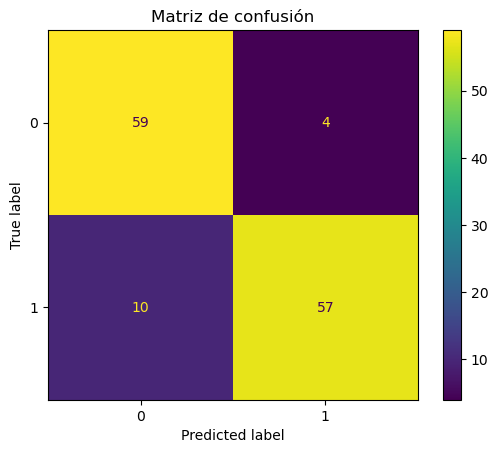

In [45]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.3f} ")

precision = precision_score(y_test, y_pred)
print(f"Precision Score: {precision:.3f} ")

recall = accuracy_score(y_test, y_pred)
print(f"Recall Score:  {recall:.3f} ")

roc_Score = roc_auc_score(y_test, y_pred)
print(f"AUC Score: {roc_Score:.3f} ")

con_mat = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=con_mat).plot()
plt.title("Matriz de confusión")
figname = 'Consusion Matrix'
# plt.savefig(join(foldername,figname))
plt.show()


In [37]:
Modelname = 'Classifier.sav'
pickle.dump(classifier, open(os.path.join('Models',Modelname), 'wb'))